# Performing a linecut in an arbitrary direction

When performing a linecut which is along an arbitrary direction (_i.e._, not along one of the principal H, K, or L axes), we must reorient part or all of the data using the `rotate_data()` function. This is because we perform the linecuts by binning pixels along the principal axes of the `np.array` which holds the scattering data, which typically correspond to the H, K, and L axes of reciprocal space. By rotating the data, we can bring the reciprocal space direction of interest to align with the principal axes of the array, simplifying the steps to obtain the resulting linecut.

<img src="https://github.com/stevenjgomez/nxs_analysis_tools/blob/main/docs/source/examples/img/rotate_data.png?raw=true" alt="Data rotation">

## Step 1: Rotate data

First, let's load the data. Here we use a simulated dataset output from the DISCUS software as an example.

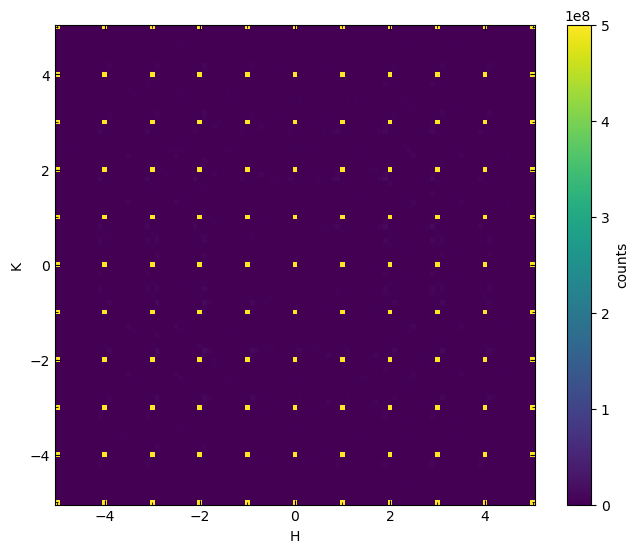

In [1]:
from nxs_analysis_tools.datareduction import load_discus_nxs, plot_slice
from nxs_analysis_tools.datasets import vacancies

# Load the dataset
data_dir = vacancies() # Download the example dataset into cache directory
data = load_discus_nxs(data_dir)
plot_slice(data[:,:,0.0], vmin=0, vmax=5e8)

Next, we will use `rotate_data()` to perform the rotation. We must provide several additional parameters that indicate the nature of the rotation. Because we are interested in performing a linecut along the 110 direction here, we seek to rotate about the 001 axis in reciprocal space by 45 degrees in order to bring the 110 reflection onto the x axis of the array.

We must specify the angle between the two reciprocal lattice vectors that are perpendicular to the rotation axis: because the angle between the 100 and 010 axes is 90 degrees for this system, we specify `lattice_angle=90`. Because the two axes of interest (a* and b*) are of equal length, this will work just fine. However, in the more general case that they are unequal, we need to provide the `aspect` parameter, which specifies the aspect ratio between the coordinates of the two principal axes of the plane to be rotated. We will see an example of this below when we try to perform a second rotation in the _HHL_ plane.

Next, we specify the rotation angle as `rotation_angle=-45`. This is always defined to rotate the data counter-clockwise relative to its original orientation.

Lastly, we specify that we are rotating about the 001 vector (L direction) by setting `rotation_axis=2` (`0`=_H_, `1`=_K_, and `2`=_L_ for this dataset, but verify the axis order for your own data).

Note: This can take a long time. If the linecut you are interested in depends only on a small range of reciprocal space that can be rotated, you may want to select a subset of your data for rotation. Here, because we are interested in a linecut along the 110 direction, it is sufficient to select data ranging from -1.0<L<1.0.

In [2]:
from nxs_analysis_tools.datareduction import rotate_data

# Rotate the dataset
rotated_110 = rotate_data(data, lattice_angle=90, rotation_angle=-45, rotation_axis=2)


Rotation completed.


Let's visualize HK0 plane of the rotated dataset!

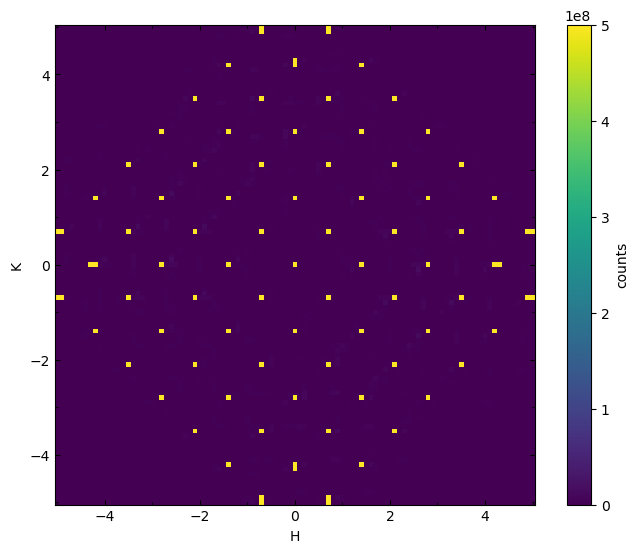

In [3]:
# Plot the data
plot_slice(rotated_110[:,:,0.0], vmin=0, vmax=5e8)

## Step 2: Scaling corrections

You may notice that the indices on the x axis and y axis of our plot are incorrect. See below that the reflections are now at unusual coordinates.

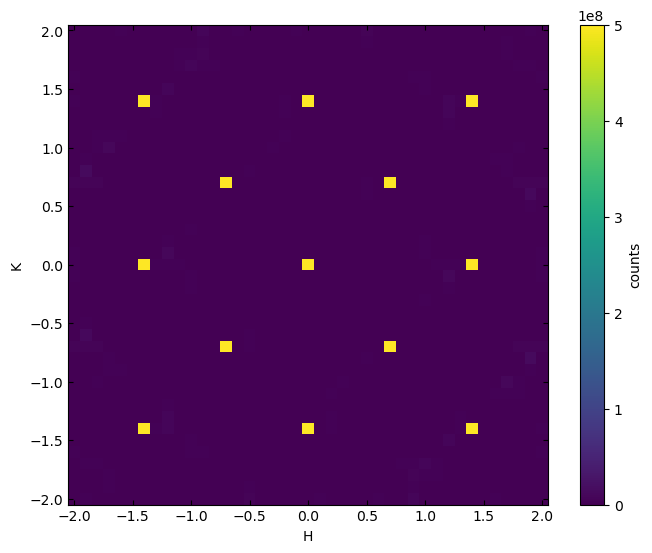

In [4]:
# Taking a closer look...
plot_slice(rotated_110[-2.0:2.0,-2.0:2.0,0.0], vmin=0, vmax=5e8)

We need to correct this to reflect that the x axis is now the 110 direction, and the y axis is now the -110 direction. This involves both a re-labeling and a scaling of the existing axes. We accomplish the latter by calculating the ratio between the lengths of the reciprocal space vectors 110 and 100.

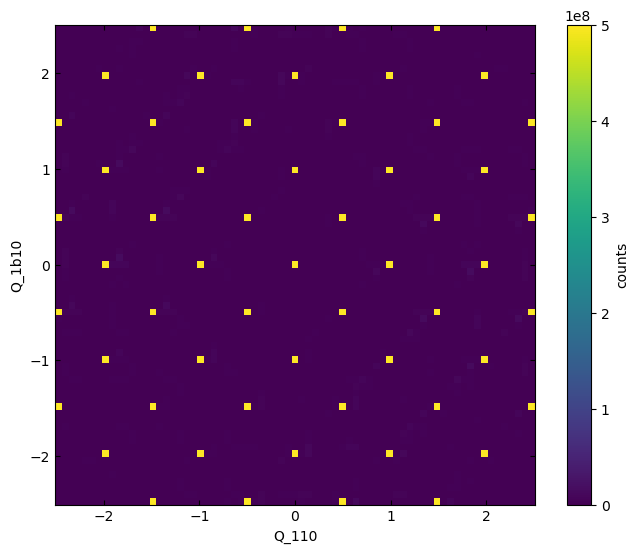

In [5]:
import numpy as np
from nexusformat.nexus import NXdata, NXfield

# Ratio between lengths of 110 and 100 vector
ratio = np.sqrt(1**2 + 1**2 + 0**2) / np.sqrt(1**2 + 0**2 + 0**2)

# Scale x and y axes, relabel all three for consistency
Q_110 = NXfield(rotated_110.H.nxdata / ratio, name='Q_110')
Q_1b10 = NXfield(rotated_110.K.nxdata / ratio, name='Q_1b10')
Q_001 = NXfield(rotated_110.L, name='Q_001')

# Create a new NXdata object with the scaled H and K axes
rotated_110_scaled = NXdata(signal=rotated_110.counts, axes=(Q_110, Q_1b10, Q_001))

plot_slice(rotated_110_scaled[-2.5:2.5,-2.5:2.5,0.0], vmin=0, vmax=5e8)

Now that we have the data correctly rotated and labeled, we can use `Scissors` to perform our linecut.

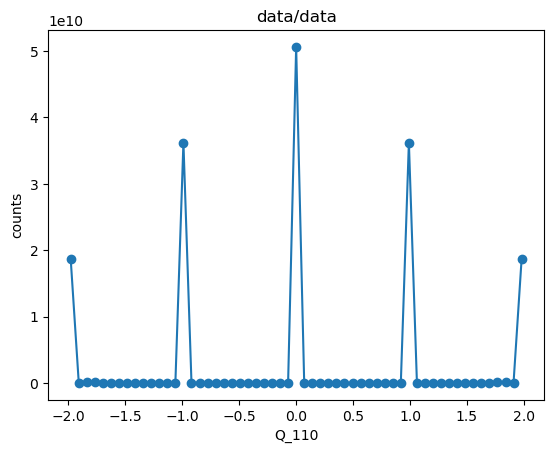

In [6]:
from nxs_analysis_tools.datareduction import Scissors

s = Scissors()
s.set_data(rotated_110_scaled)
s.cut_data(center=(0,0,0), window=(2,0.2,0.2))
s.linecut.plot(ls='-')

## Performing a rotation of a plane with unequal coordinate axis lengths

More generally, the plane we want to rotate will be defined by two axes, let's call these a* and b*, which are not equal in magnitude, and may not be separated by an angle of 90 degrees. For the case of a general lattice angle, we have already seen that the `lattice_angle` parameter can be provided to indicate the angle between a* and b*. We will now explore how to use the `aspect` parameter to specify the relative lengths of these two principal vectors defining the plane.

Let's assume we begin with our `rotated_110_scaled` from above, whose basis vectors are (1,1,0), (-1,1,0), and (0,0,1). We can check this by examining the `.tree` attribute of the data.

In [7]:
# Let's examine the structure of scaled_data
print(rotated_110_scaled.tree)

data:NXdata
  @axes = ['Q_110', 'Q_1b10', 'Q_001']
  @signal = 'counts'
  Q_001 = float64(101)
  Q_1b10 = float64(101)
  Q_110 = float64(101)
  counts = float64(101x101x101)


Our next goal is to take a linecut along the (1,1,1) direction, which requires another rotation. Our previous rotation already allows us access to the plane spanned by (1,1,0) and (0,0,1), meaning that the (1,1,1) direction should lie along the diagonal of this plane. 

Let's plot the _HHL_ plane to visualise this. In order to plot this correctly, we will need to set the `aspect` of the `matplotlib` axes to respect the different lengths of the (1,1,0) and (0,0,1) axes. Here, we assume the lattice parameters to be a=b=c=1 and alpha=beta=gamma=90. We can use the `reciprocal_lattice_params()` function to calculate the reciprocal lattice parameters, which will help us define the lengths of these vectors.

[None]

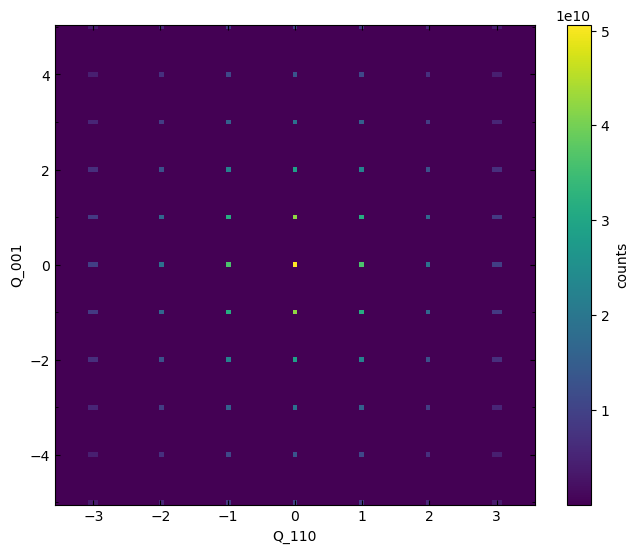

In [8]:
from nxs_analysis_tools.datareduction import reciprocal_lattice_params
import matplotlib.pyplot as plt

# Define lattice parameters
a = 1 
b = 1
c = 1
al = 90
be = 90
ga = 90

# Calculate reciprocal lattice parameters
a_, b_, c_, al_, be_, ga_ = reciprocal_lattice_params((a,b,c,al,be,ga))


# Calculate the relative lengths of the two axes to be plotted
len_110 = np.sqrt(1 * a_ ** 2 + 1 * b_ ** 2 + 0 * c_ ** 2)
len_001 = np.sqrt(0 * a_ ** 2 + 0 * b_ ** 2 + 1 * c_ ** 2)

# Plot the data
plot_slice(rotated_110_scaled[:,0.0,:])

# Set the aspect ratio (length of y vector / length of x vector)
plt.gca().set(aspect=len_001 / len_110)


We identify the (1,1,1) reflection as the coordinate x=1, y=1 in the above plot. In order to rotate this direction to be along the x axis of our array, we will need to rotate by the out-of-plane direction, which in this case is the (-1,1,0) or `Q_1b10` axis.

Before doing so, we must determine the necessary rotation angle. This is given by a simple trigonometric expression:

In [9]:
rotation_angle_110_to_111 = np.arctan(len_001 / len_110)
rotation_angle_110_to_111 = np.rad2deg(rotation_angle_110_to_111)

print(f'Rotation angle is {rotation_angle_110_to_111:.2f} degrees')

Rotation angle is 35.26 degrees


In order to perform the rotation, we again use `rotate_data` but specify the `aspect` to be ratio between the lengths of the y and x vectors defining the plane. Note the negative `rotation_angle` is needed in order to rotate the data clockwise.

In [10]:
rotated_111 = rotate_data(rotated_110_scaled, lattice_angle=90, 
                          rotation_angle=-rotation_angle_110_to_111, rotation_axis=1, # axis 1 = Q_1b10
                          aspect=len_001 / len_110,
                          rotation_order=1, # Change the order of the spline interpolation to avoid data losses
                          aspect_order=1, # Change the order of the spline interpolation to avoid data losses
                         )


Rotation completed.


Let's visualize the data to verify the result.

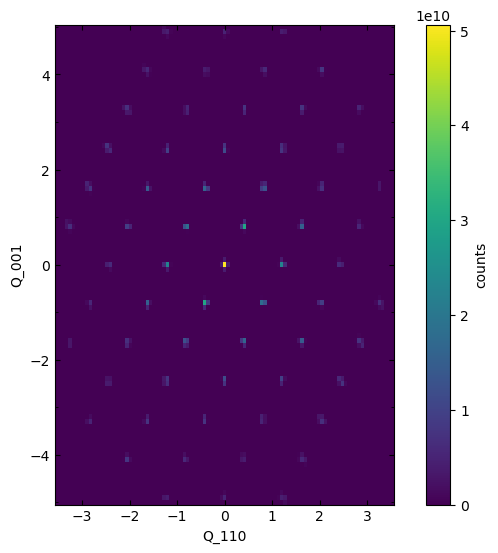

In [11]:
plot_slice(rotated_111[:,0.0,:])

Again, while the rotation succeeded in bringing the (1,1,1) direction to the x-axis, we still need to rescale the axes to reflect the relative scales of the new x axis (1,1,1) and the new y axis (-1,-1,2). Therefore our new `NXdata` object will have axes:

- `0`: `( 1, 1, 1)`
- `1`: `(-1, 1, 0)` [this axis is left unchanged by the current rotation]
- `2`: `(-1,-1, 2)`

[None]

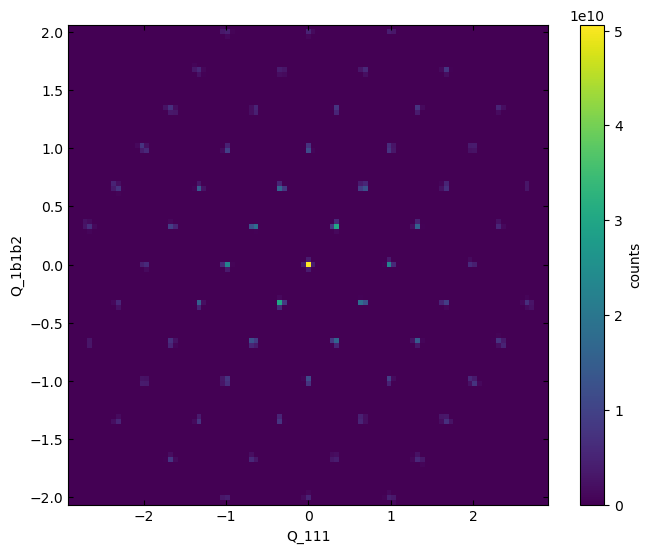

In [12]:
# Ratio between lengths of 111 and 110 vector (len_110 is defined earlier), will be used to scale the x axis
len_111 = np.sqrt((1 * a_) ** 2 + (1 * b_) ** 2 + (1 * c_) ** 2)
ratio_111 = len_111 / len_110

# Ratio between lengths of -1-12 and 001 vector, will be used to rescale the y axis
len_112 = np.sqrt((-1 * a_) ** 2 + (-1 * b_) ** 2 + (2 * c_) ** 2)
ratio_112 = len_112 / len_001

# Scale axes, relabel for consistency
Q_111 = NXfield(rotated_111.nxaxes[0] / ratio_111, name='Q_111')
# [Q_1b10 remains unchanged]
Q_1b1b2 = NXfield(rotated_111.nxaxes[2] / ratio_112, name='Q_1b1b2')

# Create a new NXdata object with the scaled axes
rotated_111_scaled = NXdata(signal=rotated_111.counts, axes=(Q_111, Q_1b10, Q_1b1b2))

plot_slice(rotated_111_scaled[:,0.0,:])
plt.gca().set(aspect=len_112 / len_111)

Now, the axes reflect the proper scaling.